# Goals

This notebook tests the calibration of the variance estimates from our three Shapley value estimators, i.e., how well the estimates match up with the variance observed when running the estimators repeatedly. The three estimators are:

- Approximate regression (Section 3.2 of [this paper](https://arxiv.org/abs/2012.01536))
- Unbiased regression (Section 3.3 of [this paper](https://arxiv.org/abs/2012.01536))
- Permutation sampling

# Load data, train model

In [1]:
import sage
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bank()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev Outcome']
categorical_inds = [feature_names.index(col) for col in categorical_cols]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [4]:
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.3,
                           depth=10)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

# Setup

In [5]:
import matplotlib.pyplot as plt
from shapreg import removal, games, shapley, shapley_unbiased, shapley_sampling

In [6]:
# Make model callable
model_lam = lambda x: model.predict_proba(x)[:, 1]

# Model extension
marginal_extension = removal.MarginalExtension(train[:128], model_lam)

# Set up game
game = games.PredictionGame(marginal_extension, test[0])

# Approximate regression

- These variance estimates are not very well calibrated, there are noticeable estimation errors in both directions.

In [7]:
explanation_list = []
for i in range(100):
    explanation = shapley.ShapleyRegression(game, bar=False, verbose=False, n_samples=2048, batch_size=64)
    explanation_list.append(explanation)

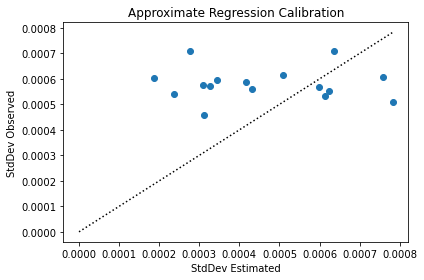

In [8]:
plt.figure()

# Scatter plot
std_est = explanation_list[0].std
std_real = np.std(np.array([explanation.values for explanation in explanation_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot([0, m,], [0, m], color='black', linestyle=':')

plt.xlabel('StdDev Estimated')
plt.ylabel('StdDev Observed')
plt.title('Approximate Regression Calibration')

plt.tight_layout()
plt.show()

# Unbiased regression

- The calibration here is better, but there are still some errors.

In [9]:
explanation_list = []
for i in range(100):
    explanation = shapley_unbiased.ShapleyRegression(game, bar=False, verbose=False, n_samples=2048)
    explanation_list.append(explanation)

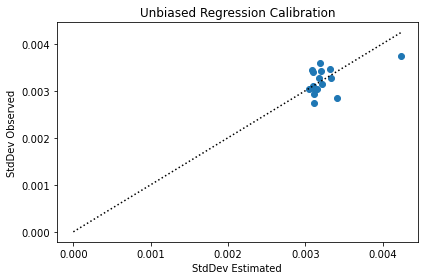

In [10]:
plt.figure()

# Scatter plot
std_est = explanation_list[0].std
std_real = np.std(np.array([explanation.values for explanation in explanation_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot([0, m,], [0, m], color='black', linestyle=':')

plt.xlabel('StdDev Estimated')
plt.ylabel('StdDev Observed')
plt.title('Unbiased Regression Calibration')

plt.tight_layout()
plt.show()

# Permutation sampling

- Very good calibration.

In [11]:
explanation_list = []
for i in range(100):
    explanation = shapley_sampling.ShapleySampling(game, bar=False, verbose=False, n_samples=64, batch_size=64)
    explanation_list.append(explanation)

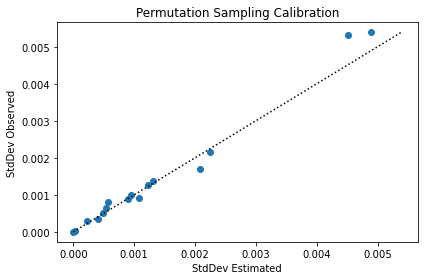

In [12]:
plt.figure()

# Scatter plot
std_est = explanation_list[0].std
std_real = np.std(np.array([explanation.values for explanation in explanation_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot([0, m,], [0, m], color='black', linestyle=':')

plt.xlabel('StdDev Estimated')
plt.ylabel('StdDev Observed')
plt.title('Permutation Sampling Calibration')

plt.tight_layout()
plt.show()